In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

from emccd_detect import emccd_detect
meta_path = Path('/home/kianmilani/Projects/emccd_detect/emccd_detect/emccd_detect/util/metadata.yaml')

dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2024-02-07 08:27:39,198	INFO worker.py:1636 -- Started a local Ray instance.


1.3624486320346218e-17 sr


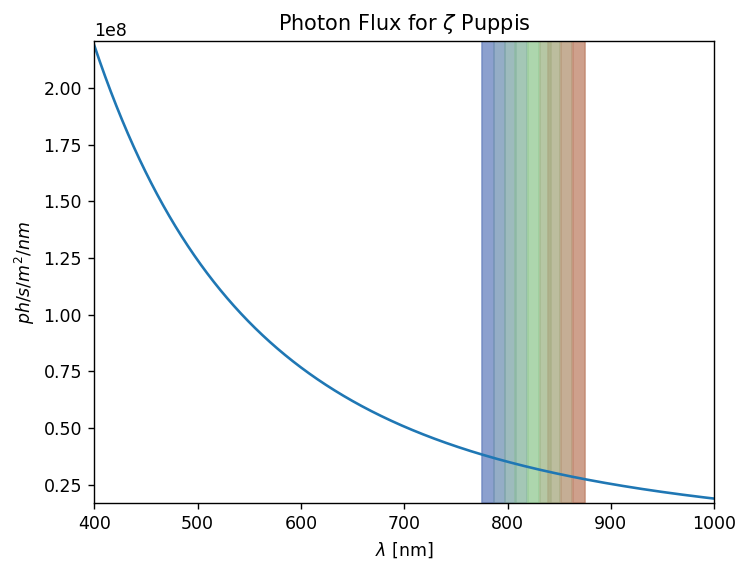

In [3]:
reload(cgi_phasec_poppy.source_flux)
wavelength_c = 825e-9*u.m

nbands = 3
nwaves = 3

lam_a = 792e-9*u.m
bandwidth = 2.8/100
minwave = lam_a * (1 - bandwidth/2)
maxwave = lam_a * (1 + bandwidth/2)
wavelengths_a = np.linspace( minwave, maxwave, nwaves )

lam_b = 825e-9*u.m
bandwidth = 2.9/100
minwave = lam_b * (1 - bandwidth/2)
maxwave = lam_b * (1 + bandwidth/2)
wavelengths_b = np.linspace( minwave, maxwave, nwaves )

lam_c = 857e-9*u.m
bandwidth = 2.8/100
minwave = lam_c * (1 - bandwidth/2)
maxwave = lam_c * (1 + bandwidth/2)
wavelengths_c = np.linspace( minwave, maxwave, nwaves )

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun
zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=np.concatenate([wavelengths_a, wavelengths_b, wavelengths_c,]),
                                           temp=40000*u.K,distance=300*u.parsec,diameter=2*14*R_sun,name='$\zeta$ Puppis', 
                                           lambdas=lambdas,
                                           )
zpup.plot_spectrum_ph()



In [11]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors_a = []
for i in range(nwaves):
    actors_a.append(rayCGI.options(num_cpus=2, num_gpus=1/9).remote(**kwargs))
    actors_a[i].setattr.remote('wavelength', wavelengths_a[i])
mode_a = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors_a, 
                                                           dm1_ref=2*dm1_flat, 
                                                        #    dm2_ref=dm2_flat, 
                                                          )
actors_b = []
for i in range(nwaves):
    actors_b.append(rayCGI.options(num_cpus=2, num_gpus=1/9).remote(**kwargs))
    actors_b[i].setattr.remote('wavelength', wavelengths_b[i])
mode_b = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors_b, 
                                                           dm1_ref=2*dm1_flat, 
                                                        #    dm2_ref=dm2_flat, 
                                                          )
actors_c = []
for i in range(nwaves):
    actors_c.append(rayCGI.options(num_cpus=2, num_gpus=1/9).remote(**kwargs))
    actors_c[i].setattr.remote('wavelength', wavelengths_c[i])
mode_c = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors_c, 
                                                           dm1_ref=2*dm1_flat, 
                                                        #    dm2_ref=dm2_flat, 
                                                          )

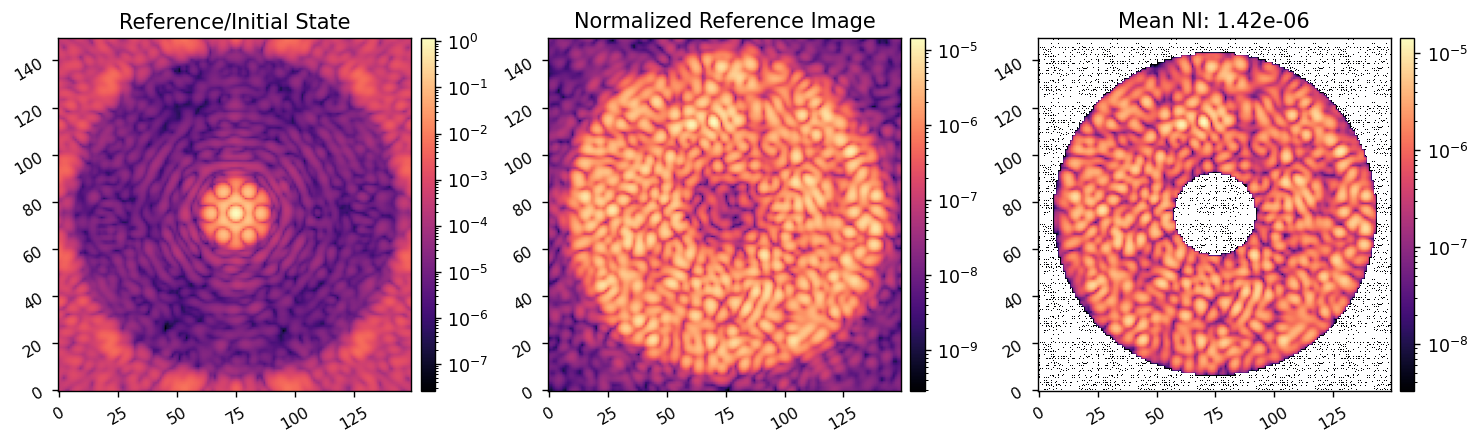

In [10]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode_a.set_actor_attr('use_fpm',False)
raw_im = mode_b.snap()
mode_a.Imax_ref = xp.max(raw_im)

ref_unocc_im = mode_a.snap()

mode_a.set_actor_attr('use_fpm',True)
ref_im = mode_a.snap()

control_mask = utils.create_annular_focal_plane_mask(mode_a, inner_radius=5.4, outer_radius=20.6, edge=None)
mean_ni = xp.mean(ref_im[control_mask])
imshow3(ref_unocc_im, ref_im, ref_im*control_mask, 
        f'Reference/Initial State', 
        'Normalized Reference Image',
        f'Mean NI: {mean_ni:.2e}',
        lognorm=True,)


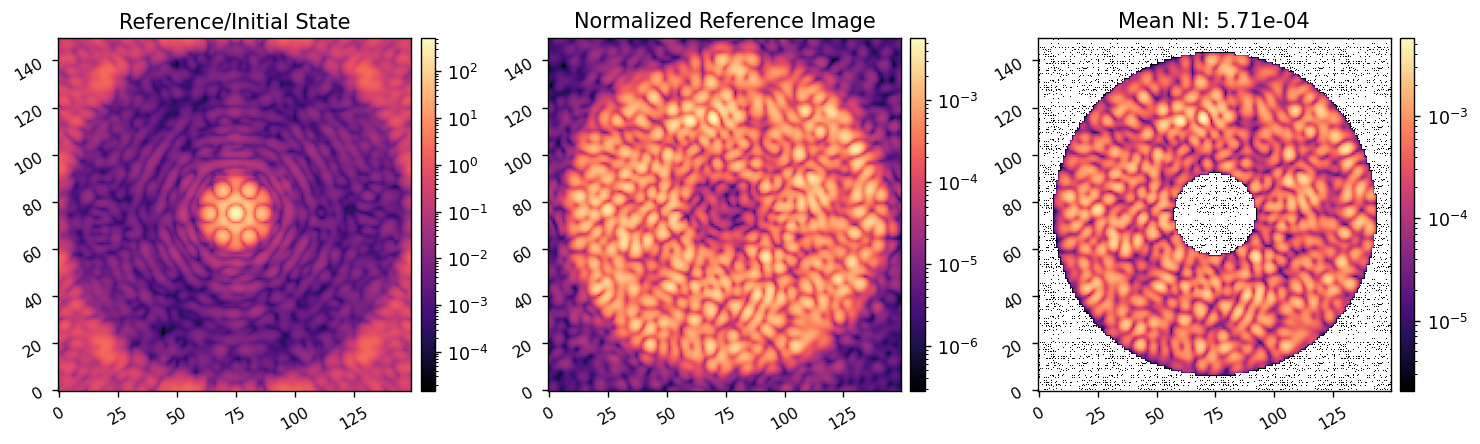

In [8]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode_b.set_actor_attr('use_fpm',False)
raw_im = mode_b.snap()
mode_b.Imax_ref = xp.max(raw_im)

ref_unocc_im = mode_b.snap()

mode_b.set_actor_attr('use_fpm',True)
ref_im = mode_b.snap()

mean_ni = xp.mean(ref_im[control_mask])
imshow3(ref_unocc_im, ref_im, ref_im*control_mask, 
        f'Reference/Initial State', 
        'Normalized Reference Image',
        f'Mean NI: {mean_ni:.2e}',
        lognorm=True,)

# Create calibration and probe modes

In [5]:
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.2,
                                          shift=[(-12,7), (12,7),(0,-14), (0,0)], nprobes=3,
                                           use_weighting=True)
imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+mode.Nacts,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


NameError: name 'mode' is not defined

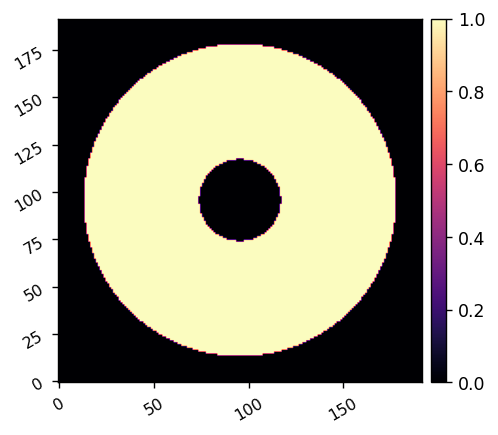

(4096,)


In [8]:
reload(utils)
oversamp = 4

had_modes = xp.array(calib_modes)
ft_modes = []
for i in range(calib_modes.shape[0]//2):
    had_mode = had_modes[i,:mode.Nact**2].reshape(mode.Nact, mode.Nact)
    ft_modes.append(xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(utils.pad_or_crop(had_mode, mode.Nact*oversamp)))))
mode_freqs = xp.abs(xp.array(ft_modes))**2

mode_freq_mask_pxscl = 1/oversamp
x = (xp.linspace(-mode.Nact*oversamp//2, mode.Nact*oversamp//2-1, mode.Nact*oversamp) + 1/2)*mode_freq_mask_pxscl
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2+y**2)
mode_freq_mask = (r>5.4)*(r<20.6)
imshow1(mode_freq_mask)

sum_vals = []
max_vals = []
for i in range(calib_modes.shape[0]//2):
    sum_vals.append(xp.sum(mode_freqs[i, mode_freq_mask]))
    max_vals.append(xp.max(mode_freqs[i, mode_freq_mask]))

biggest_sum = xp.max(xp.array(sum_vals))
biggest_max = xp.max(xp.array(max_vals))

scale_factors = []
for i in range(calib_modes.shape[0]//2):
    scale_factors.append((biggest_max/max_vals[i])**(1/3))
    # scale_factors.append(xp.exp(-(biggest_max/max_vals[i]-1)))
scale_factors = ensure_np_array(xp.array(scale_factors))
# scale_factors[scale_factors>2] = 2
# scale_factors[scale_factors<1/2] = 1/2

scale_factors = np.concatenate([scale_factors,scale_factors])
print(scale_factors.shape)

In [20]:
mode.exp_times_list = np.array([0.01, 0.2])
mode.Nframes_list = np.array([10, 2])

total_exp_time = np.sum(mode.exp_times_list*mode.Nframes_list)
print(f'Total exposure time: {total_exp_time:.2f}s')


Total exposure time: 0.50s


Total exposure time: 2.00s
Calibrating iEFC...
	Calibrated mode 1/3 in 12.421s
		Scale Factor = 2.19, Calibration amplitude = 1.10e-08m
	Calibrated mode 2/3 in 24.836s
		Scale Factor = 2.47, Calibration amplitude = 1.23e-08m
	Calibrated mode 3/3 in 37.178s
		Scale Factor = 1.00, Calibration amplitude = 5.00e-09m

Calibration complete.


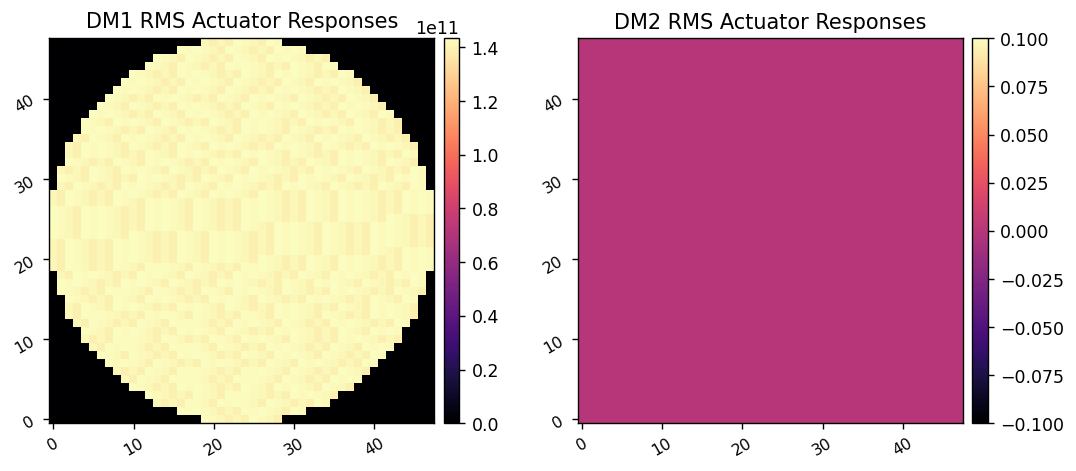

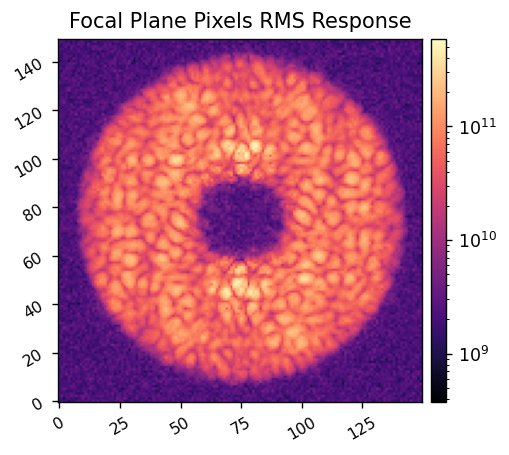

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_matrix_20240124.fits


In [41]:
reload(iefc_2dm)

mode.reset_dms()
total_exp_time = np.sum(mode.exp_times_list*mode.Nframes_list)
print(f'Total exposure time: {total_exp_time:.2f}s')

calib_amp = 5e-9
probe_amp = 20e-9

response_matrix, response_cube, calib_amps = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                     calib_amp, calib_modes[190:193], 
                                                     scale_factors=scale_factors[190:193], 
                                                     return_all=True, 
#                                                     plot_responses=False,
                                                   )

utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
# utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [9]:
date = 20240124
date = 20240201
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_band4b_emccd_response_matrix_{date}.fits'))
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'spc_wide_825_poke_modes_response_cube_{date}.fits'))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096                                                  
NAXIS2  =                40572                                                  
EM_GAIN =                  750                                                  

9683096209460.434


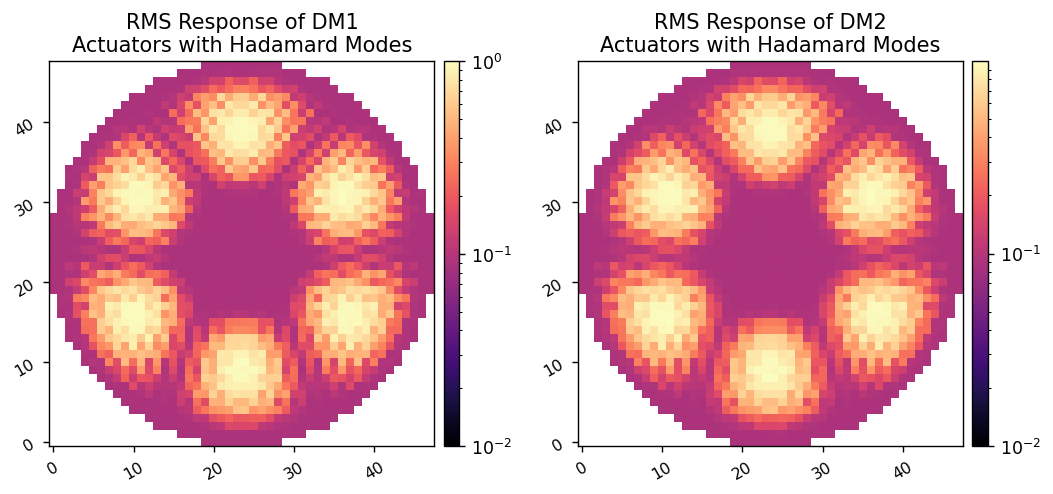

In [10]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Hadamard Modes', 'RMS Response of DM2\nActuators with Hadamard Modes',
        lognorm=True, vmin1=0.01, vmin2=0.01,
        )


# Run IEFC

In [11]:
mode.reset_dms()
images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])
regs = xp.array([])

mode.reset_dms()

In [14]:
mode.exp_times_list, mode.Nframes_list

([0.25, 2.5, 5], [4, 2, 1])

In [33]:
xp.min(xp.abs(im[~xp.isnan(xp.abs(im))]))

array(6.17673085e-12)

Running iEFC...
	Closed-loop iteration 28 / 30
False
False


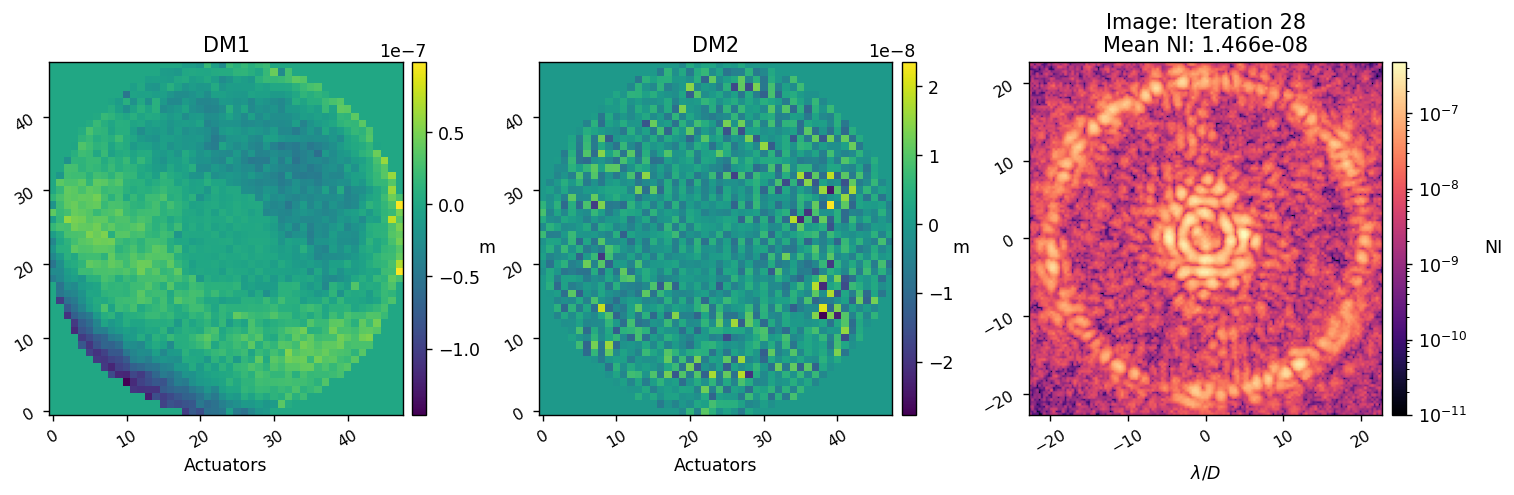

	Closed-loop iteration 29 / 30
False
False


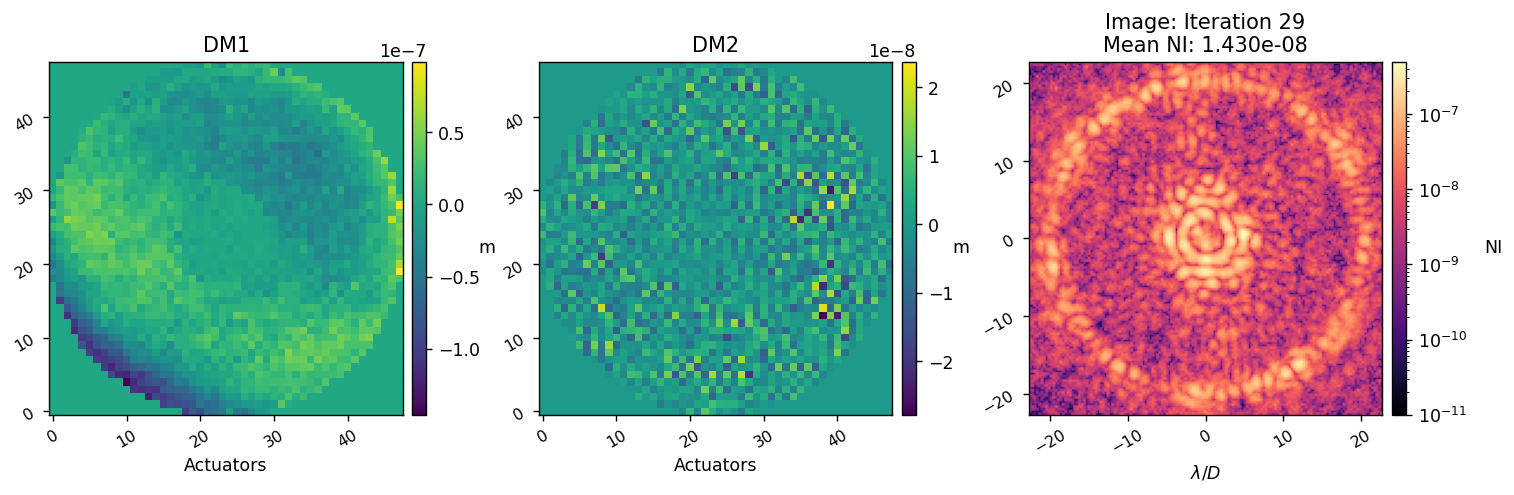

	Closed-loop iteration 30 / 30
False
False


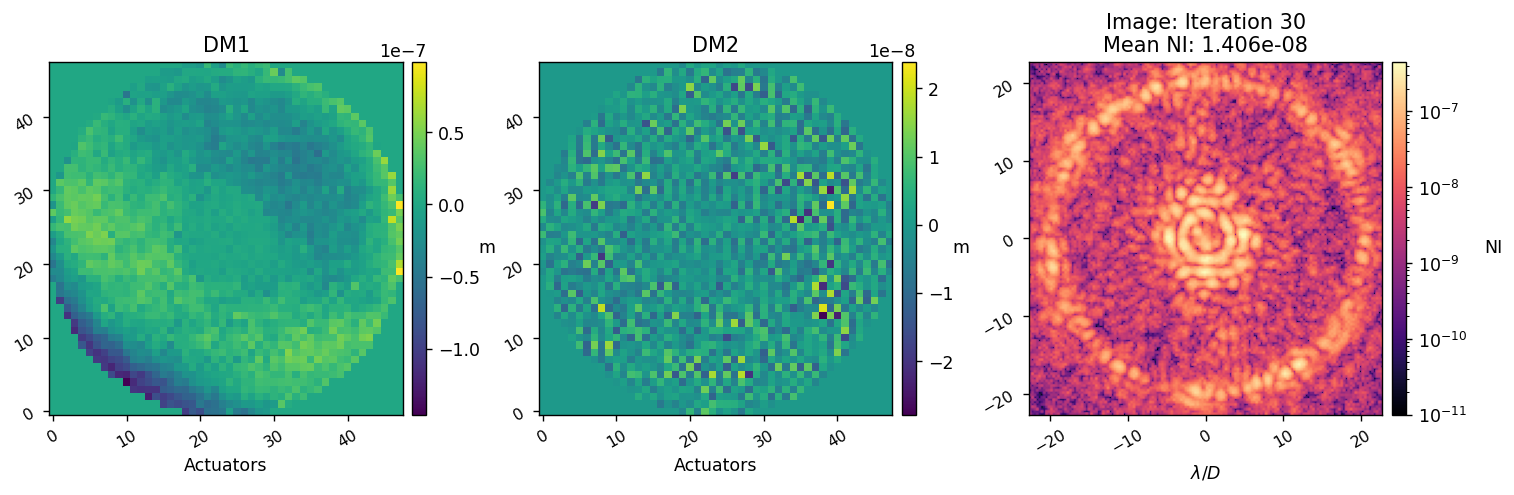

Closed loop for given control matrix completed in 23.964s.


In [41]:
reload(iefc_2dm)
reload(utils)

mode.normalize = True

reg_fun = utils.beta_reg
reg_conds = -2.5
reg_conds = -4
# reg_conds = -5
# reg_conds = -6

images, dm1_commands, dm2_commands, regs = iefc_2dm.run(mode, 
                                                        response_matrix,
                                                        reg_fun, reg_conds, 
                                                        probe_modes, 
                                                        probe_amp, 
                                                        calib_modes,
                                                        control_mask, 
                                                        num_iterations=3, 
                                                        loop_gain=0.5, 
                                                        leakage=0,
                                                        probe_exp_time=probe_exp_times,
                                                        probe_nframes=probe_Nframes,
                                                        probe_em_gain=probe_em_gain,
                                                        metric_exp_time=metric_exp_times,
                                                        metric_nframes=metric_Nframes,
                                                        metric_em_gain=metric_em_gain,
                                                        plot_all=True,
                                                        plot_radial_contrast=False,
                                                        old_images=images,
                                                        old_dm1_commands=dm1_commands,
                                                        old_dm2_commands=dm2_commands,
                                                        old_regs=regs,
                                              )

In [42]:
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_dm1_commands_{today}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_dm2_commands_{today}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_images_{today}.fits', images)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_regs_{today}.fits', regs)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_dm1_commands_20240202.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_dm2_commands_20240202.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_images_20240202.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_regs_20240202.fits
